1. 过多的数据预处理会影响精度，标准化会使一部分特征丢失。
2. 由于类别分布不均匀，需要对权重进行调整。
3. 过于复杂的模型反而会导致过拟合。
4. 为了缓解过拟合，使用早停+学习率衰减。
5. 图片的对比度、亮度、旋转方式对模型性能有较大影响。
6. 为缓解过拟合，冻结前面的模型、只训练后面部分。

**ResNet (Residual Networks):** Introduced by Microsoft in 2015, ResNet revolutionized the field of deep learning by enabling the training of very deep neural networks with 100+ layers efficiently. The key innovation in ResNet was the introduction of "residual connections" or "skip connections." These connections allow the input of one layer to skip some layers and be added to the output of a later layer. This helps in alleviating the vanishing gradient problem, where the gradient becomes too small for effective learning in deep networks.

**Anti-Aliasing in ResNetAA:** Anti-Aliasing techniques are used to address the problem of aliasing, which occurs when high-frequency signals (like sharp edges in images) are undersampled and produce artifacts. In the context of CNNs, anti-aliasing is often implemented through techniques like blurring or downsampling layers. The ResNetAA model integrates such anti-aliasing techniques into the ResNet architecture, potentially improving its performance in handling high-frequency features in images.

**Applications and Performance:** Like ResNet, the ResNetAA model is primarily used for image classification tasks. However, due to its anti-aliasing capabilities, it can perform better in scenarios where handling of high-frequency details is critical, such as in medical imaging or satellite imagery.

**Compatibility with Existing Frameworks:** ResNetAA, being a variation of ResNet, is compatible with major deep learning frameworks like TensorFlow and PyTorch. This allows for easy integration into existing projects and applications.

In summary, ResNetAA builds on the strengths of the ResNet architecture by incorporating anti-aliasing techniques, making it more adept at handling images with high-frequency details.

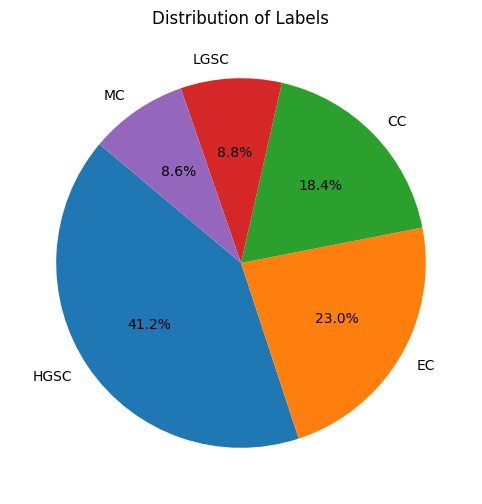

label
HGSC    0.005650
EC      0.010101
CC      0.012658
LGSC    0.026316
MC      0.027027
Name: count, dtype: float64


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
df = pd.read_csv('/kaggle/input/cs640-1/train.csv')

# 统计每个标签的数量
label_counts = df['label'].value_counts()

# 绘制饼状图
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels')
plt.show()
# 计算总数
total_count = len(df)

# 计算每个类别的频率
frequencies = label_counts / total_count

# 计算权重（频率的倒数）
weights = 1.0 / label_counts

# 打印权重
print(weights)


In [6]:
import os
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Subset, Dataset
from sklearn.model_selection import KFold
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay

PIL.Image.MAX_IMAGE_PIXELS = 933120000000
LR = 5e-4
EPOCHS = 100
BATCH_SIZE = 4
N_SPLITS = 5
N_ACCUMULATE = 16
MODEL_NAME = 'resnetaa50d.d_in12k'
Image_size = 512
WEIGHT_DECAY = 1e-4
num_classes = 5

X_train shape: (430, 512, 512, 3)
Y_train shape: (430,)
X_train shape: (430, 512, 512, 3)


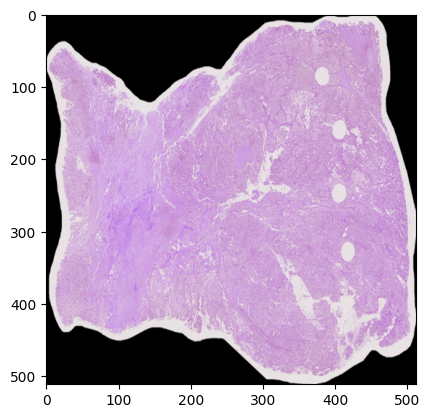

In [7]:
# Load the saved .npy files
X_train_path = '/kaggle/input/cs640-npy/X_train_1024.npy'  # replace with the actual path
Y_train_path = '/kaggle/input/cs640-npy/Y_train_1024.npy'  # replace with the actual path

# Check if the files exist before loading them
if os.path.exists(X_train_path) and os.path.exists(Y_train_path):
    X_train = np.load(X_train_path)
    Y_train = np.load(Y_train_path)
else:
    print("Files not found. Please check the paths.")

# Verify the shape of arrays
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")

print(f"X_train shape: {X_train.shape}")
X_train_tensor = torch.tensor(X_train).float()
Y_train_tensor = torch.from_numpy(Y_train).long()  # assume Y_train contains integer class labels
plt.imshow(X_train_tensor[0]/255)
plt.show()

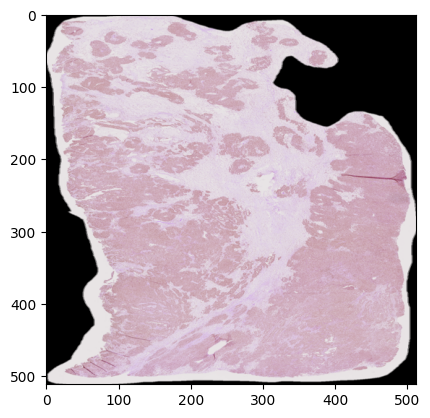

torch.Size([512, 512, 3])
5


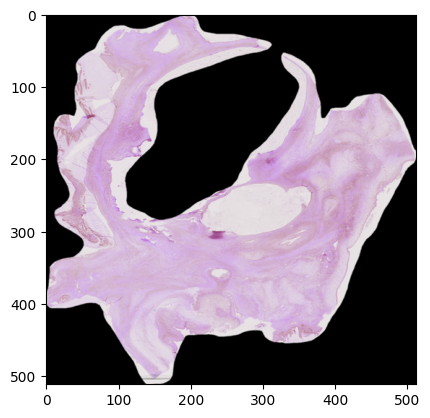

In [8]:

X_train_tensor = X_train_tensor.view(-1, Image_size, Image_size, 3)
dataset = TensorDataset(X_train_tensor, Y_train_tensor)
# Split the dataset into a training set and a validation set
train_idx, val_idx = train_test_split(
    np.arange(len(X_train)),
    test_size=0.2,  # reserve 20% for validation
    random_state=43,  # guarantee repeatability
    stratify=Y_train  # keep data distribution consistent
)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

train_labels = [dataset.tensors[1][i].item() for i in train_idx]
val_labels = [dataset.tensors[1][i].item() for i in val_idx]

train_images = [dataset[i][0] for i in train_idx]
val_images = [dataset[i][0] for i in val_idx]

plt.imshow(train_images[0]/255)
plt.show()
print(train_images[0].shape)

Y_train = np.array(Y_train)  # convert to numpy array if not already
class_sample_count = np.array([len(np.where(Y_train[train_idx] == t)[0]) for t in np.unique(Y_train[train_idx])])

weights = 1. / class_sample_count
samples_weights = np.array([weights[t] for t in Y_train[train_idx]])

# Convert to a PyTorch tensor
samples_weights = torch.from_numpy(samples_weights)
samples_weights = samples_weights.double()

# Create a sampler for weighted sampling
sampler = WeightedRandomSampler(samples_weights, len(samples_weights))

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(len(np.unique(Y_train)))

first_batch_images, first_batch_labels = next(iter(train_loader))

plt.imshow(first_batch_images[0]/255)
plt.show()

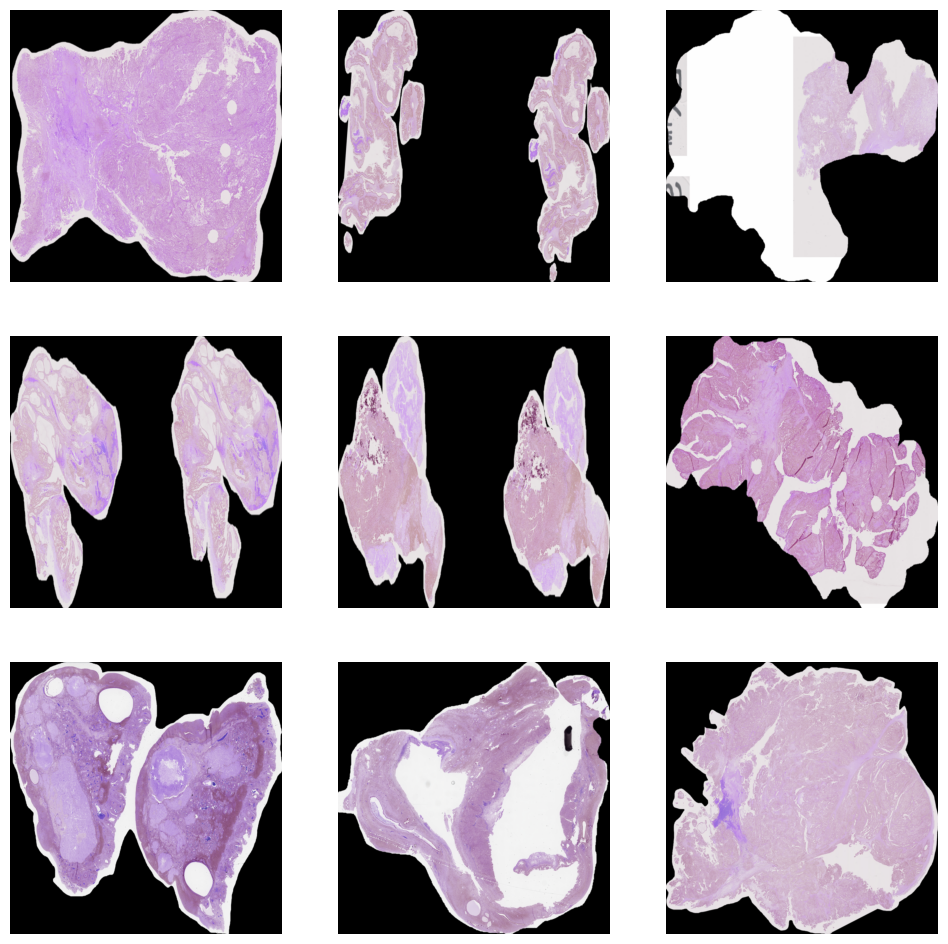

In [9]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# 定义图像变换
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomVerticalFlip(),    # 随机垂直翻转
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    # 根据需要加入和调整以下转换
    # transforms.CenterCrop((224, 224)),  # 中心裁剪
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

# 假设 X_train_tensor 包含训练图像
# 输出前9张图片
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i in range(9):
    # 获取图像并进行归一化
    img = X_train_tensor[i] / 255
    img = img.permute(2, 0, 1)

    # 应用转换
    img = image_transforms(img)

    # 重新排列维度以便于显示
    img = img.permute(1, 2, 0)

    # 显示图像
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')

plt.show()

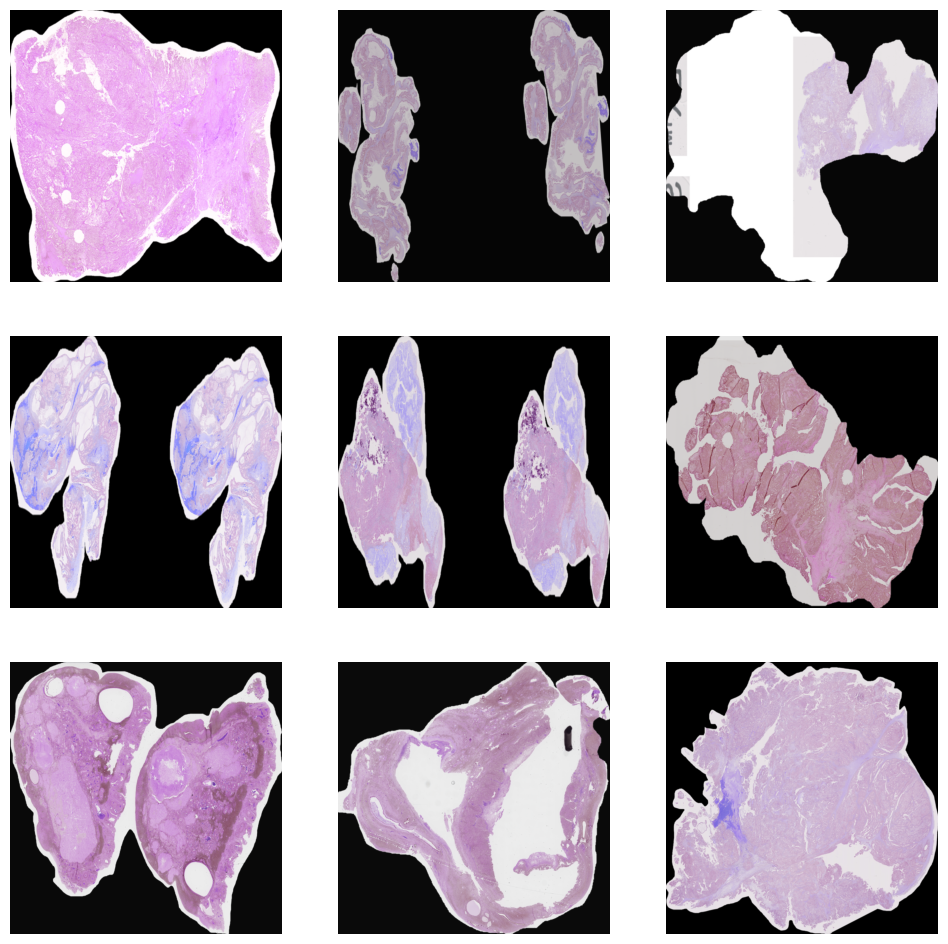

In [10]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# 定义图像变换
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomVerticalFlip(),    # 随机垂直翻转
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    # 根据需要加入和调整以下转换
    # transforms.CenterCrop((224, 224)),  # 中心裁剪
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

# 假设 X_train_tensor 包含训练图像
# 输出前9张图片
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i in range(9):
    # 获取图像并进行归一化
    img = X_train_tensor[i] / 255
    img = img.permute(2, 0, 1)

    # 应用转换
    img = image_transforms(img)

    # 重新排列维度以便于显示
    img = img.permute(1, 2, 0)

    # 显示图像
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')

plt.show()

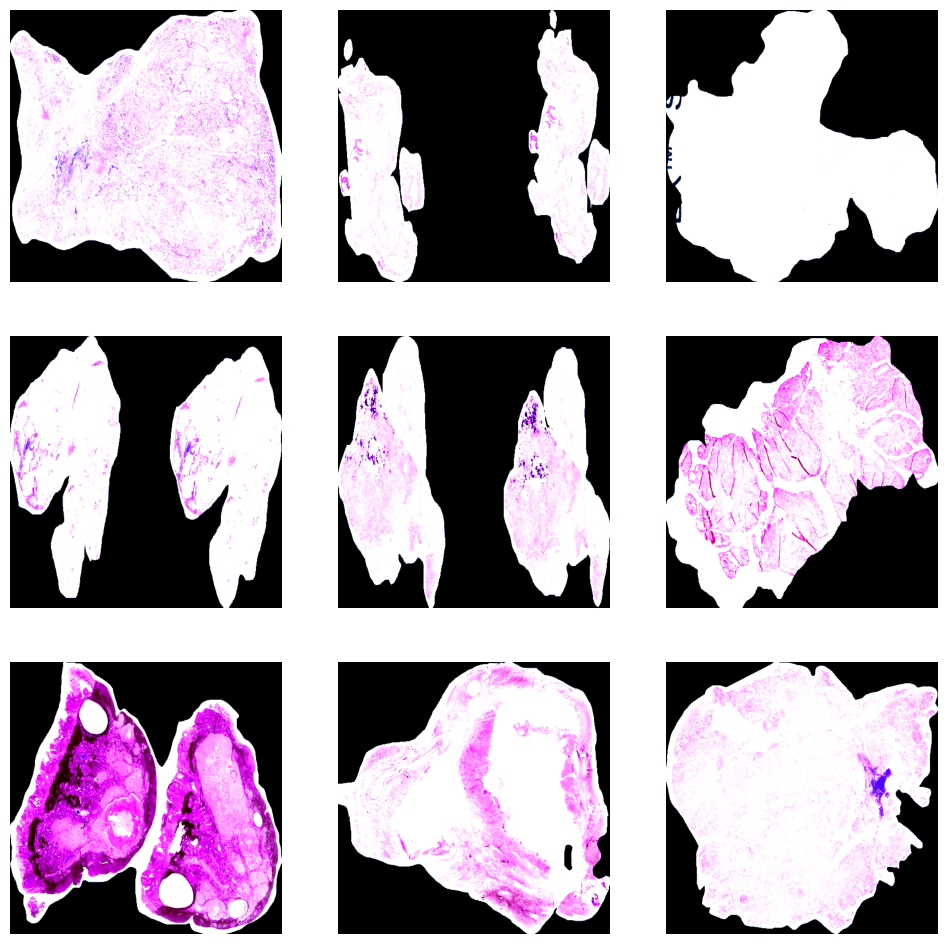

In [11]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# 定义图像变换
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomVerticalFlip(),    # 随机垂直翻转
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    # 根据需要加入和调整以下转换
    # transforms.CenterCrop((224, 224)),  # 中心裁剪
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

# 假设 X_train_tensor 包含训练图像
# 输出前9张图片
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i in range(9):
    # 获取图像并进行归一化
    img = X_train_tensor[i] / 255
    img = img.permute(2, 0, 1)

    # 应用转换
    img = image_transforms(img)

    # 重新排列维度以便于显示
    img = img.permute(1, 2, 0)

    # 显示图像
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')

plt.show()

seed(2)
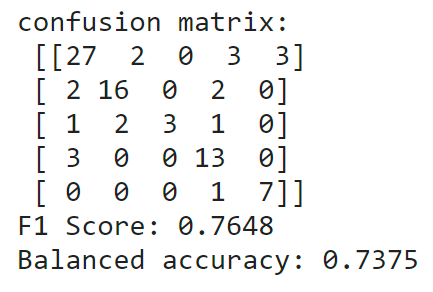

seed(0)
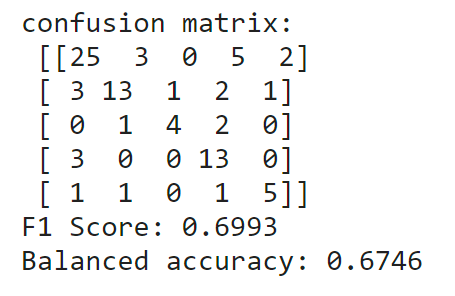

seed(100)
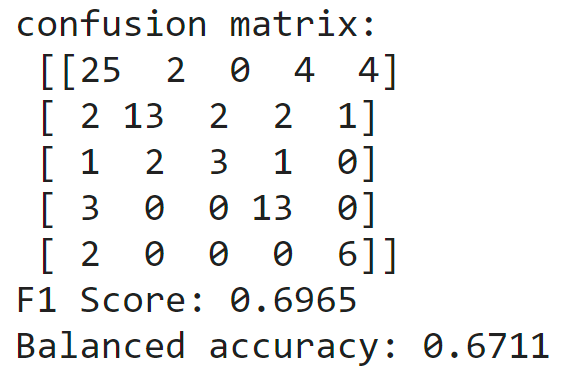

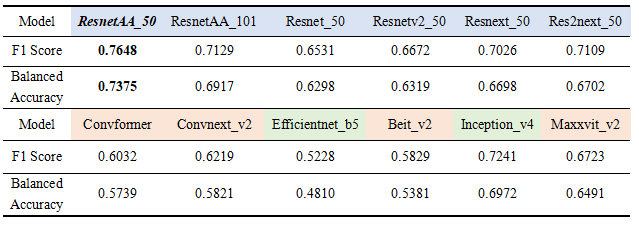